<a href="https://colab.research.google.com/github/HasanNayon/AI-Driven-Personalized-Treatment-Response-Prediction/blob/main/treatment_response_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Youth Mental Health Treatment Response Prediction
## AI-Driven Decision Support System

**Project Goal:** Predict individual patient response to different therapeutic interventions using clinical data, therapy notes, digital interactions, and self-reported text.

**Target Variable:** Treatment response (responder/partial/non-responder)

**Key Features:**
- 🧠 Multimodal data: Structured clinical + Unstructured text + Behavioral signals
- 🤖 LLM-based feature extraction from therapy notes and social media posts
- 📊 Multiple modeling approaches: Baseline → Advanced deep learning
- 🎯 Clinical decision support focus

---

### Notebook Sections:
1. Setup & Data Loading
2. Exploratory Data Analysis
3. Data Preprocessing
4. Feature Engineering (Text Embeddings)
5. Baseline Models
6. Advanced Models (LLM-Enhanced)
7. Model Evaluation & Interpretation
8. Clinical Insights & Recommendations

---

**Environment:** Google Colab compatible ✅  
**Runtime:** GPU recommended for transformer models

## 1. Setup & Installation

Install required packages for text processing and machine learning.

In [49]:
# Check if running in Google Colab
try:
    import google.colab
    IN_COLAB = True
    print("Running in Google Colab")
except:
    IN_COLAB = False
    print("Running locally")

# Install required packages
!pip install -q sentence-transformers transformers scikit-learn pandas numpy matplotlib seaborn
!pip install -q wordcloud textblob imbalanced-learn

print("\nAll packages installed successfully!")

✅ Running in Google Colab

✅ All packages installed successfully!


## 2. Import Libraries

In [50]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, f1_score, roc_auc_score, roc_curve)

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Text processing
from sentence_transformers import SentenceTransformer
from textblob import TextBlob
import re

# Imbalanced learning
from imblearn.over_sampling import SMOTE

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")

✅ Libraries imported successfully!


## 3. Mount Google Drive (for Colab users)

Upload your dataset to Google Drive and mount it here.

In [51]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

    # Set your dataset path in Google Drive
    # Modify this path based on where you uploaded the Dataset folder
    DATA_PATH = '/content/drive/MyDrive/data/processed'
    print(f"Google Drive mounted. Dataset path: {DATA_PATH}")
else:
    # Local path
    DATA_PATH = 'd:/mental health/Dataset/'
    print(f"Using local dataset path: {DATA_PATH}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive mounted. Dataset path: /content/drive/MyDrive/data/processed


## 4. Load Data

In [52]:
# Load primary patient data
print("Loading datasets...")

# Main patient profiles with outcomes
patients_df = pd.read_csv(DATA_PATH + '/patient_profiles.csv')
print(f"Patient profiles: {patients_df.shape}")

# Therapy session notes
therapy_notes_df = pd.read_csv(DATA_PATH + '/therapy_notes.csv')
print(f"Therapy notes: {therapy_notes_df.shape}")

# Digital therapy chats
digital_chats_df = pd.read_csv(DATA_PATH + '/digital_therapy_chats.csv')
print(f"Digital chats: {digital_chats_df.shape}")

# Patient Reddit posts
reddit_posts_df = pd.read_csv(DATA_PATH + '/patient_reddit_posts.csv')
print(f"Reddit posts: {reddit_posts_df.shape}")

print("\nAll datasets loaded successfully!")

📂 Loading datasets...
✅ Patient profiles: (3000, 14)
✅ Therapy notes: (20771, 6)
✅ Digital chats: (40440, 6)
✅ Reddit posts: (7223, 7)

✅ All datasets loaded successfully!


## 5. Exploratory Data Analysis (EDA)

In [53]:
# Display first few rows
print("-" * 60)
print("PATIENT PROFILES SAMPLE")
print("-" * 60)
display(patients_df.head())

print("\n" + "-" * 60)
print("DATASET OVERVIEW")
print("-" * 60)
print(patients_df.info())

print("\n" + "-" * 60)
print("BASIC STATISTICS")
print("-" * 60)
display(patients_df.describe())

PATIENT PROFILES SAMPLE


,patient_id,age,gender,baseline_phq9,baseline_gad7,baseline_severity,treatment_type,treatment_duration_weeks,session_attendance_rate,digital_engagement_score,outcome_phq9,outcome_gad7,treatment_response,improvement_percentage
0,P0001,19,M,14,20,mild-moderate,CBT,10,0.829,0.000,8,11,partial,41.6
1,P0002,20,F,15,13,moderate,Medication,18,0.862,0.000,8,7,partial,43.5
2,P0003,18,M,15,11,moderate,Medication,18,0.900,0.000,9,6,partial,37.8
3,P0004,17,M,11,21,mild-moderate,CBT+Digital,12,0.894,0.751,4,9,responder,56.5
4,P0005,13,M,21,20,severe,CBT+Digital,14,0.825,0.702,13,12,partial,36.7



DATASET OVERVIEW
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   patient_id                3000 non-null   object 
 1   age                       3000 non-null   int64  
 2   gender                    3000 non-null   object 
 3   baseline_phq9             3000 non-null   int64  
 4   baseline_gad7             3000 non-null   int64  
 5   baseline_severity         3000 non-null   object 
 6   treatment_type            3000 non-null   object 
 7   treatment_duration_weeks  3000 non-null   int64  
 8   session_attendance_rate   3000 non-null   float64
 9   digital_engagement_score  3000 non-null   float64
 10  outcome_phq9              3000 non-null   int64  
 11  outcome_gad7              3000 non-null   int64  
 12  treatment_response        3000 non-null   object 
 13  improvement_percentage    3000 non-null   flo

,age,baseline_phq9,baseline_gad7,treatment_duration_weeks,session_attendance_rate,digital_engagement_score,outcome_phq9,outcome_gad7,improvement_percentage
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,17.643333,17.443667,15.490667,12.192667,0.821113,0.318737,8.764667,7.529667,48.165267
std,2.851461,4.057871,3.446139,3.408629,0.099833,0.388411,4.355564,3.341184,17.707248
min,13.000000,11.000000,10.000000,6.000000,0.550000,0.000000,2.000000,1.000000,5.000000
25%,15.000000,14.000000,12.000000,10.000000,0.753000,0.000000,5.000000,5.000000,35.875000
50%,18.000000,17.000000,16.000000,12.000000,0.838000,0.000000,8.000000,7.000000,48.400000
75%,20.000000,21.000000,18.000000,14.000000,0.898000,0.744000,12.000000,10.000000,61.200000
max,22.000000,24.000000,21.000000,18.000000,0.980000,0.950000,22.000000,19.000000,80.000000


TARGET VARIABLE DISTRIBUTION

Counts:
treatment_response
responder        1404
partial          1288
non-responder     308
Name: count, dtype: int64

Percentages:
responder: 46.8%
partial: 42.9%
non-responder: 10.3%


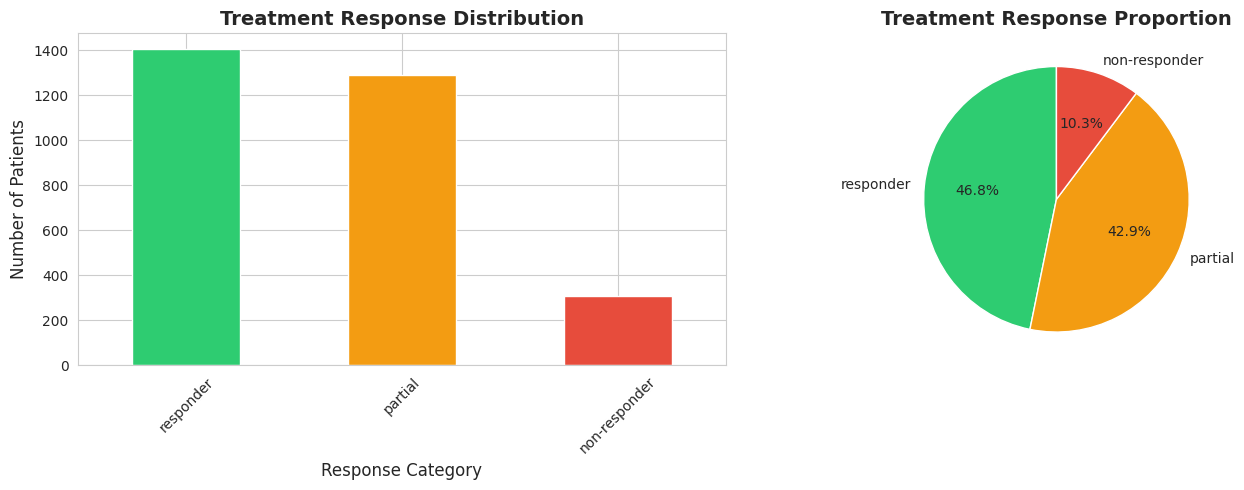

In [54]:
# Target variable distribution
print("-" * 60)
print("TARGET VARIABLE DISTRIBUTION")
print("-" * 60)

response_counts = patients_df['treatment_response'].value_counts()
response_pcts = patients_df['treatment_response'].value_counts(normalize=True) * 100

print("\nCounts:")
print(response_counts)
print("\nPercentages:")
for resp, pct in response_pcts.items():
    print(f"{resp}: {pct:.1f}%")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
response_counts.plot(kind='bar', ax=axes[0], color=['#2ecc71', '#f39c12', '#e74c3c'])
axes[0].set_title('Treatment Response Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Response Category', fontsize=12)
axes[0].set_ylabel('Number of Patients', fontsize=12)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

# Pie chart
axes[1].pie(response_counts, labels=response_counts.index, autopct='%1.1f%%',
            colors=['#2ecc71', '#f39c12', '#e74c3c'], startangle=90)
axes[1].set_title('Treatment Response Proportion', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

TREATMENT TYPE DISTRIBUTION
treatment_type
CBT+Digital        629
CBT+Medication     627
Digital_Therapy    599
Medication         588
CBT                557
Name: count, dtype: int64


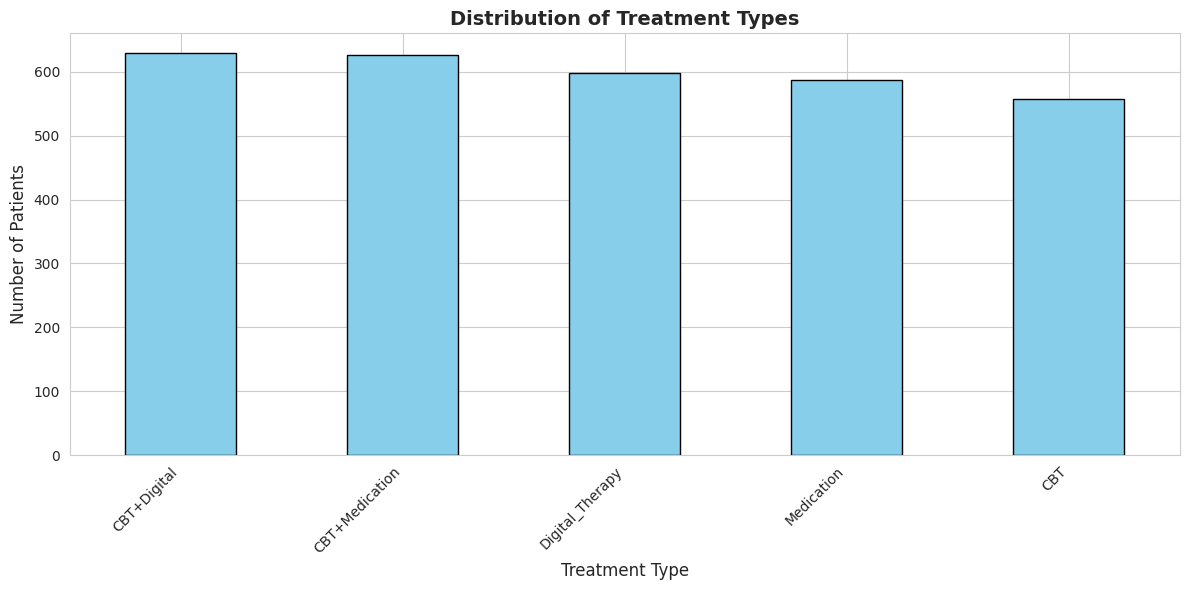

In [55]:
# Treatment type distribution
print("-" * 60)
print("TREATMENT TYPE DISTRIBUTION")
print("-" * 60)

treatment_counts = patients_df['treatment_type'].value_counts()
print(treatment_counts)

plt.figure(figsize=(12, 6))
treatment_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Treatment Types', fontsize=14, fontweight='bold')
plt.xlabel('Treatment Type', fontsize=12)
plt.ylabel('Number of Patients', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

TREATMENT RESPONSE BY TREATMENT TYPE


treatment_response,non-responder,partial,responder
treatment_type,,,
CBT,8.4,45.6,46.0
CBT+Digital,2.5,27.2,70.3
CBT+Medication,3.3,34.4,62.2
Digital_Therapy,22.9,54.8,22.4
Medication,14.8,54.3,31.0


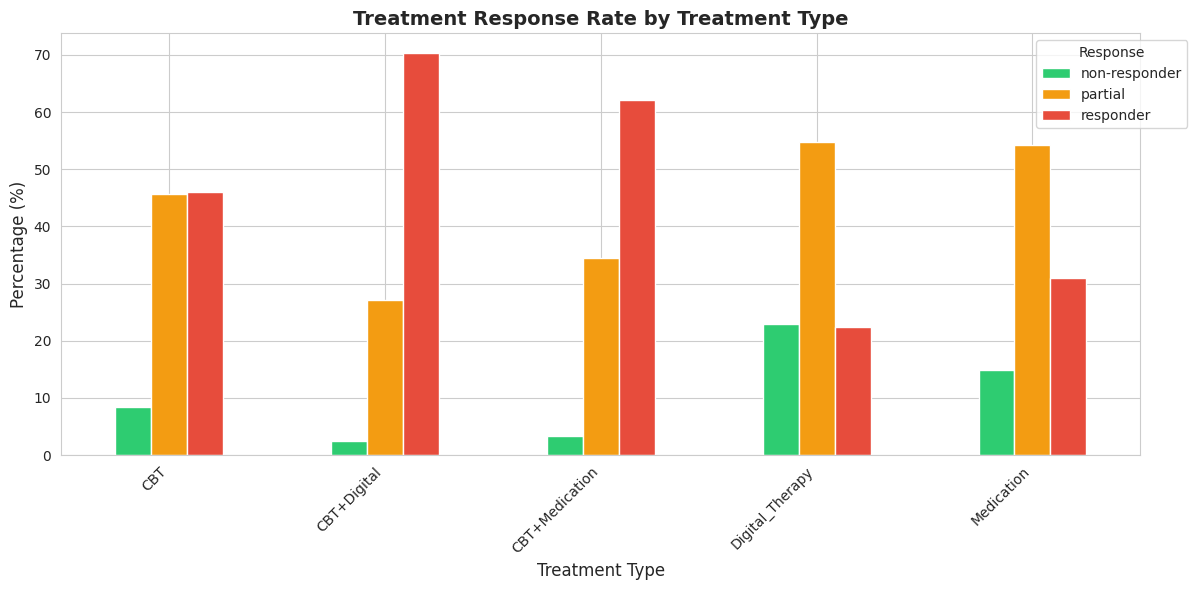

In [56]:
# Treatment response by treatment type
print("-" * 60)
print("TREATMENT RESPONSE BY TREATMENT TYPE")
print("-" * 60)

response_by_treatment = pd.crosstab(
    patients_df['treatment_type'],
    patients_df['treatment_response'],
    normalize='index'
) * 100

display(response_by_treatment.round(1))

# Visualize
response_by_treatment.plot(kind='bar', stacked=False, figsize=(12, 6),
                           color=['#2ecc71', '#f39c12', '#e74c3c'])
plt.title('Treatment Response Rate by Treatment Type', fontsize=14, fontweight='bold')
plt.xlabel('Treatment Type', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.legend(title='Response', bbox_to_anchor=(1.05, 1))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

BASELINE SEVERITY ANALYSIS


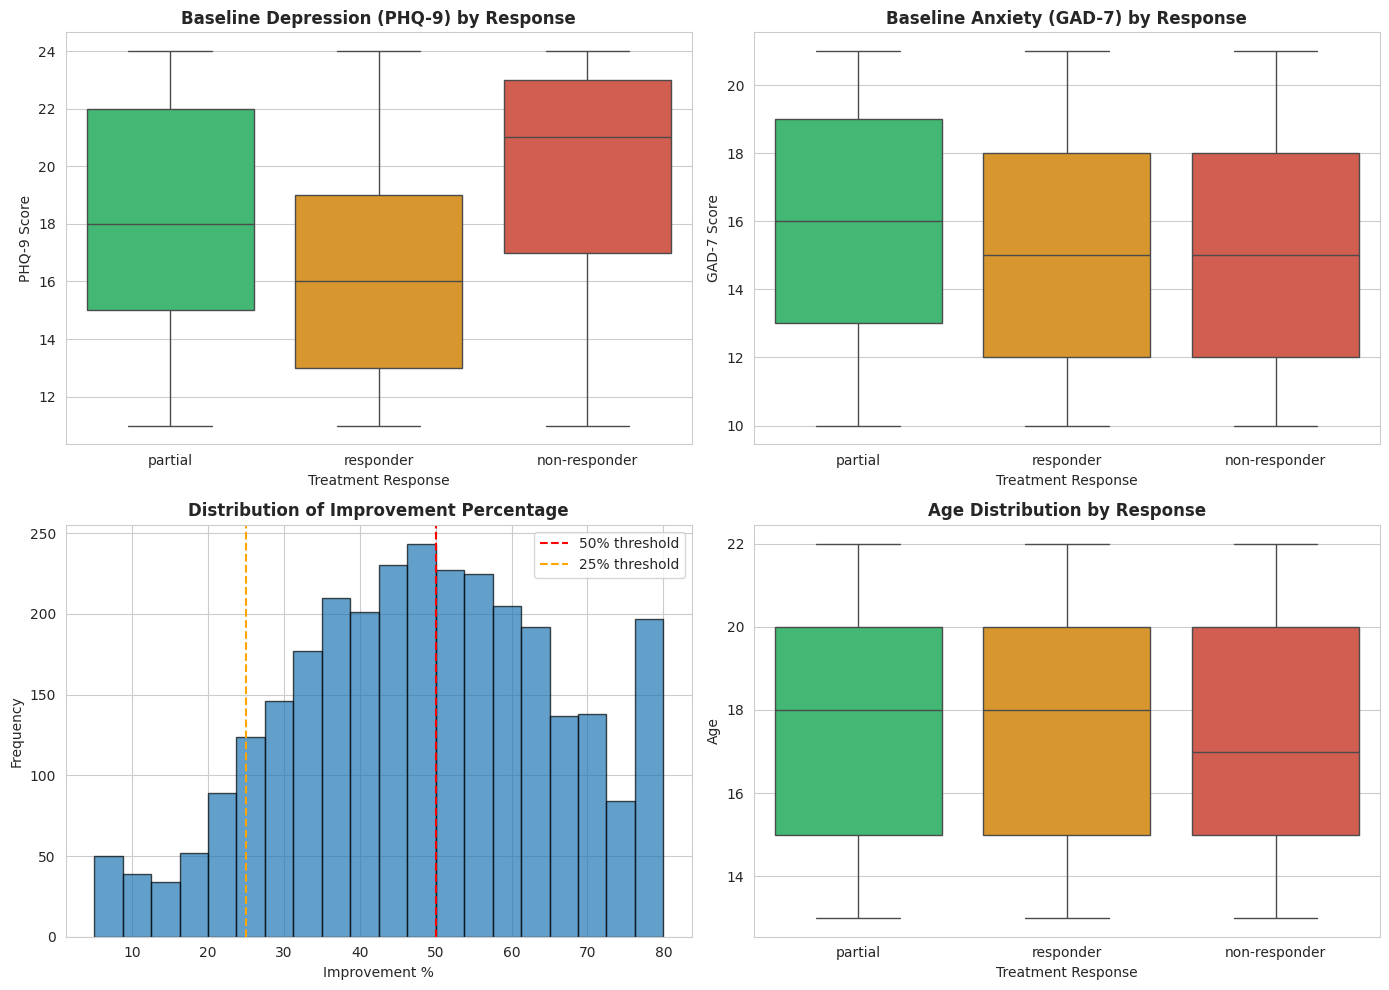

In [57]:
# Baseline severity analysis
print("-" * 60)
print("BASELINE SEVERITY ANALYSIS")
print("-" * 60)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# PHQ-9 by response
sns.boxplot(data=patients_df, x='treatment_response', y='baseline_phq9', ax=axes[0,0],
            palette=['#2ecc71', '#f39c12', '#e74c3c'])
axes[0,0].set_title('Baseline Depression (PHQ-9) by Response', fontweight='bold')
axes[0,0].set_xlabel('Treatment Response')
axes[0,0].set_ylabel('PHQ-9 Score')

# GAD-7 by response
sns.boxplot(data=patients_df, x='treatment_response', y='baseline_gad7', ax=axes[0,1],
            palette=['#2ecc71', '#f39c12', '#e74c3c'])
axes[0,1].set_title('Baseline Anxiety (GAD-7) by Response', fontweight='bold')
axes[0,1].set_xlabel('Treatment Response')
axes[0,1].set_ylabel('GAD-7 Score')

# Improvement distribution
axes[1,0].hist(patients_df['improvement_percentage'], bins=20, edgecolor='black', alpha=0.7)
axes[1,0].set_title('Distribution of Improvement Percentage', fontweight='bold')
axes[1,0].set_xlabel('Improvement %')
axes[1,0].set_ylabel('Frequency')
axes[1,0].axvline(x=50, color='red', linestyle='--', label='50% threshold')
axes[1,0].axvline(x=25, color='orange', linestyle='--', label='25% threshold')
axes[1,0].legend()

# Age distribution by response
sns.boxplot(data=patients_df, x='treatment_response', y='age', ax=axes[1,1],
            palette=['#2ecc71', '#f39c12', '#e74c3c'])
axes[1,1].set_title('Age Distribution by Response', fontweight='bold')
axes[1,1].set_xlabel('Treatment Response')
axes[1,1].set_ylabel('Age')

plt.tight_layout()
plt.show()

ENGAGEMENT METRICS ANALYSIS


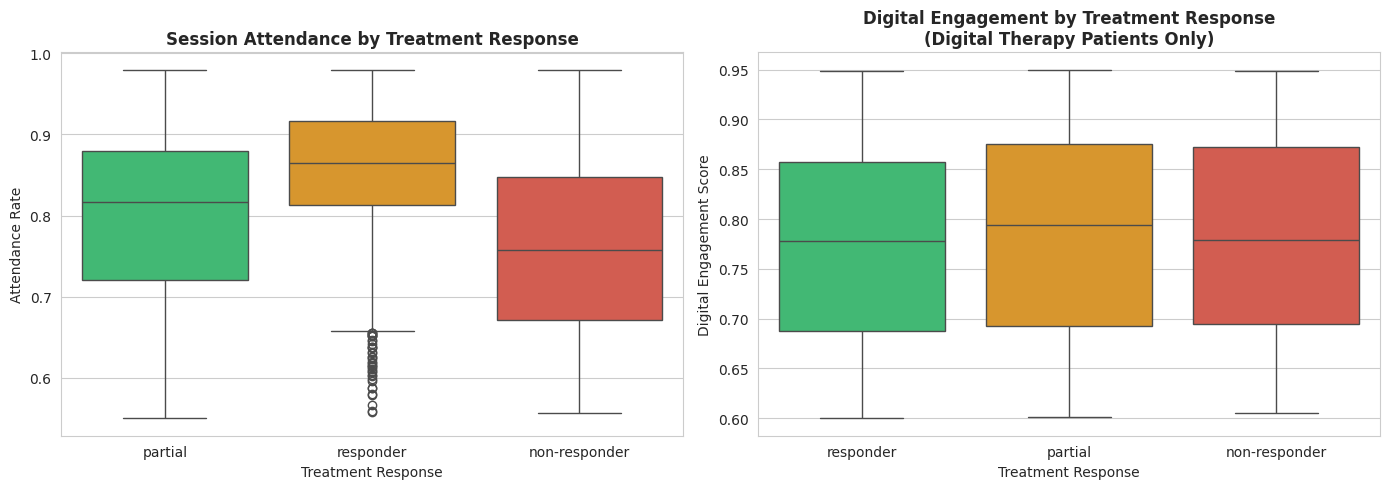


Attendance Rate Statistics:
                     count      mean       std    min      25%     50%    75%  \
treatment_response                                                              
non-responder        308.0  0.758818  0.106456  0.556  0.67075  0.7570  0.847   
partial             1288.0  0.799981  0.101640  0.550  0.72100  0.8170  0.879   
responder           1404.0  0.854166  0.083624  0.558  0.81300  0.8645  0.917   

                      max  
treatment_response         
non-responder       0.979  
partial             0.979  
responder           0.980  


In [58]:
# Engagement metrics analysis
print("-" * 60)
print("ENGAGEMENT METRICS ANALYSIS")
print("-" * 60)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Attendance rate by response
sns.boxplot(data=patients_df, x='treatment_response', y='session_attendance_rate',
            ax=axes[0], palette=['#2ecc71', '#f39c12', '#e74c3c'])
axes[0].set_title('Session Attendance by Treatment Response', fontweight='bold')
axes[0].set_xlabel('Treatment Response')
axes[0].set_ylabel('Attendance Rate')

# Digital engagement (for patients with digital therapy)
digital_patients = patients_df[patients_df['digital_engagement_score'] > 0]
sns.boxplot(data=digital_patients, x='treatment_response', y='digital_engagement_score',
            ax=axes[1], palette=['#2ecc71', '#f39c12', '#e74c3c'])
axes[1].set_title('Digital Engagement by Treatment Response\n(Digital Therapy Patients Only)',
                  fontweight='bold')
axes[1].set_xlabel('Treatment Response')
axes[1].set_ylabel('Digital Engagement Score')

plt.tight_layout()
plt.show()

print(f"\nAttendance Rate Statistics:")
print(patients_df.groupby('treatment_response')['session_attendance_rate'].describe())

## 6. Text Data Analysis

In [59]:
# Aggregate text data per patient
print("-" * 60)
print("AGGREGATING TEXT DATA PER PATIENT")
print("-" * 60)

# Aggregate therapy notes
patient_notes = therapy_notes_df.groupby('patient_id').agg({
    'therapist_notes': lambda x: ' '.join(x),
    'engagement_level': lambda x: Counter(x).most_common(1)[0][0] if len(x) > 0 else 'medium'
}).reset_index()
patient_notes.columns = ['patient_id', 'all_therapy_notes', 'dominant_engagement']

print(f"Aggregated therapy notes for {len(patient_notes)} patients")

# Aggregate digital chats (patient messages only)
patient_chats = digital_chats_df[digital_chats_df['message_type'] == 'patient'].groupby('patient_id').agg({
    'message_text': lambda x: ' '.join(x),
    'sentiment_score': 'mean'
}).reset_index()
patient_chats.columns = ['patient_id', 'all_chat_messages', 'avg_chat_sentiment']

print(f"Aggregated digital chats for {len(patient_chats)} patients")

# Aggregate Reddit posts
patient_posts = reddit_posts_df.groupby('patient_id').agg({
    'post_text': lambda x: ' '.join(x),
    'post_sentiment': 'mean',
    'emotional_intensity': 'mean'
}).reset_index()
patient_posts.columns = ['patient_id', 'all_reddit_posts', 'avg_post_sentiment', 'avg_emotional_intensity']

print(f"Aggregated Reddit posts for {len(patient_posts)} patients")

# Merge all text data with main patient data
full_df = patients_df.merge(patient_notes, on='patient_id', how='left') \
                     .merge(patient_chats, on='patient_id', how='left') \
                     .merge(patient_posts, on='patient_id', how='left')

# Fill NaN for patients without certain data sources
full_df['all_therapy_notes'] = full_df['all_therapy_notes'].fillna('')
full_df['all_chat_messages'] = full_df['all_chat_messages'].fillna('')
full_df['all_reddit_posts'] = full_df['all_reddit_posts'].fillna('')

print(f"\nCombined dataset shape: {full_df.shape}")
print(f"Text columns added: all_therapy_notes, all_chat_messages, all_reddit_posts")

display(full_df.head())

AGGREGATING TEXT DATA PER PATIENT
✅ Aggregated therapy notes for 2401 patients
✅ Aggregated digital chats for 1228 patients
✅ Aggregated Reddit posts for 3000 patients

✅ Combined dataset shape: (3000, 21)
✅ Text columns added: all_therapy_notes, all_chat_messages, all_reddit_posts


,patient_id,age,gender,baseline_phq9,baseline_gad7,baseline_severity,treatment_type,treatment_duration_weeks,session_attendance_rate,digital_engagement_score,...,outcome_gad7,treatment_response,improvement_percentage,all_therapy_notes,dominant_engagement,all_chat_messages,avg_chat_sentiment,all_reddit_posts,avg_post_sentiment,avg_emotional_intensity
0,P0001,19,M,14,20,mild-moderate,CBT,10,0.829,0.000,...,11,partial,41.6,Patient presented with mild moderate symptoms....,medium,,NaN,Therapy is okay I guess. My doctor make me go....,0.063333,0.566667
1,P0002,20,F,15,13,moderate,Medication,18,0.862,0.000,...,7,partial,43.5,Patient presented with moderate symptoms. Some...,high,,NaN,Been in therapy for few months. Some small cha...,0.100000,0.470000
2,P0003,18,M,15,11,moderate,Medication,18,0.900,0.000,...,6,partial,37.8,Mixed progress. Patient shows insight into rum...,low,,NaN,Some improvement in daily life but negative th...,0.035000,0.550000
3,P0004,17,M,11,21,mild-moderate,CBT+Digital,12,0.894,0.751,...,9,responder,56.5,Patient presented with mild moderate symptoms....,medium,Having worry today but using my coping skills....,0.606000,3 weeks post-therapy and still using my coping...,0.680000,0.482500
4,P0005,13,M,21,20,severe,CBT+Digital,14,0.825,0.702,...,12,partial,36.7,Patient attended but engagement variable. Some...,high,Some days are better than others. Today is oka...,0.095455,My treatment is helping some with depression b...,0.133333,0.500000


CREATING COMBINED TEXT FIELD
Text Length Statistics:
                     count         mean         std    min      25%     50%  \
treatment_response                                                            
non-responder        308.0  1126.353896  365.208666  438.0   826.00  1134.5   
partial             1288.0  1285.041149  399.593611  429.0  1049.00  1264.0   
responder           1404.0  1695.601852  491.966110  594.0  1363.75  1625.5   

                       75%     max  
treatment_response                  
non-responder       1374.0  2564.0  
partial             1509.0  2991.0  
responder           1940.5  3252.0  


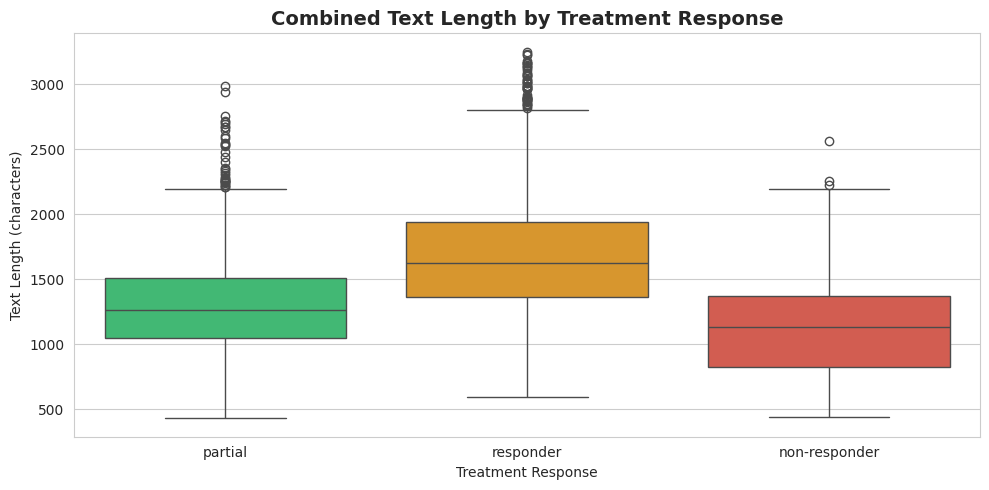

In [60]:
# Create combined text field
print("-" * 60)
print("CREATING COMBINED TEXT FIELD")
print("-" * 60)

full_df['combined_text'] = (
    full_df['all_therapy_notes'] + ' ' +
    full_df['all_chat_messages'] + ' ' +
    full_df['all_reddit_posts']
).str.strip()

# Text length statistics
full_df['text_length'] = full_df['combined_text'].str.len()

print("Text Length Statistics:")
print(full_df.groupby('treatment_response')['text_length'].describe())

# Visualize
plt.figure(figsize=(10, 5))
sns.boxplot(data=full_df, x='treatment_response', y='text_length',
            palette=['#2ecc71', '#f39c12', '#e74c3c'])
plt.title('Combined Text Length by Treatment Response', fontsize=14, fontweight='bold')
plt.xlabel('Treatment Response')
plt.ylabel('Text Length (characters)')
plt.tight_layout()
plt.show()

## 7. Feature Engineering - Text Embeddings

We'll use **Sentence-BERT** to create dense vector representations of patient text data.

In [61]:
# Load sentence transformer model
print("-" * 60)
print("LOADING SENTENCE TRANSFORMER MODEL")
print("-" * 60)

# Use a lightweight model that works well for semantic similarity
model_name = 'all-MiniLM-L6-v2'  # 384-dimensional embeddings
print(f"Loading model: {model_name}")

sentence_model = SentenceTransformer(model_name)
print(f"Model loaded successfully!")
print(f"   Embedding dimension: {sentence_model.get_sentence_embedding_dimension()}")

LOADING SENTENCE TRANSFORMER MODEL
Loading model: all-MiniLM-L6-v2


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


✅ Model loaded successfully!
   Embedding dimension: 384


In [62]:
# Generate embeddings for combined text
print("-" * 60)
print("GENERATING TEXT EMBEDDINGS")
print("-" * 60)
print("This may take a few minutes depending on dataset size...")

# Generate embeddings (with progress bar)
from tqdm import tqdm
tqdm.pandas()

text_list = full_df['combined_text'].tolist()
print(f"Encoding {len(text_list)} text samples...")

text_embeddings = sentence_model.encode(
    text_list,
    show_progress_bar=True,
    batch_size=32
)

print(f"\nGenerated embeddings with shape: {text_embeddings.shape}")

# Convert to DataFrame for easier handling
embedding_cols = [f'text_emb_{i}' for i in range(text_embeddings.shape[1])]
embeddings_df = pd.DataFrame(text_embeddings, columns=embedding_cols)

# Add embeddings to main dataframe
full_df_with_embeddings = pd.concat([full_df.reset_index(drop=True), embeddings_df], axis=1)

print(f"Combined dataframe shape: {full_df_with_embeddings.shape}")

GENERATING TEXT EMBEDDINGS
This may take a few minutes depending on dataset size...
Encoding 3000 text samples...


Batches:   0%|          | 0/94 [00:00<?, ?it/s]


✅ Generated embeddings with shape: (3000, 384)
✅ Combined dataframe shape: (3000, 407)


## 8. Prepare Training Data

In [63]:
# Select features for modeling
print("-" * 60)
print("PREPARING FEATURES FOR MODELING")
print("-" * 60)

# DEBUG: Check available columns
print("\nDEBUG: Checking available columns...")
print(f"Total columns in full_df_with_embeddings: {len(full_df_with_embeddings.columns)}")
print("\nNon-embedding columns:")
non_emb_cols = [col for col in full_df_with_embeddings.columns if not col.startswith('text_emb_')]
print(non_emb_cols)

# Check for required columns
required_cols = ['treatment_type', 'gender', 'dominant_engagement', 'age', 'baseline_phq9']
missing_cols = [col for col in required_cols if col not in full_df_with_embeddings.columns]
if missing_cols:
    print(f"\nWarning: WARNING: Missing columns: {missing_cols}")
    print("This likely means you need to reload the patient data.")
    print("Run all cells from the beginning to ensure proper data loading.")

# Structured features
structured_features = [
    'age',
    'baseline_phq9',
    'baseline_gad7',
    'treatment_duration_weeks',
    'session_attendance_rate',
    'digital_engagement_score'
]

# Text-derived features
text_derived_features = [
    'avg_chat_sentiment',
    'avg_post_sentiment',
    'avg_emotional_intensity',
    'text_length'
]

# Embedding features
embedding_features = [col for col in full_df_with_embeddings.columns if col.startswith('text_emb_')]

# Encode categorical variables
# Gender
full_df_with_embeddings['gender_encoded'] = (full_df_with_embeddings['gender'] == 'M').astype(int)

# Treatment type (one-hot encoding)
if 'treatment_type' in full_df_with_embeddings.columns:
    treatment_dummies = pd.get_dummies(full_df_with_embeddings['treatment_type'], prefix='treatment')
    full_df_with_embeddings = pd.concat([full_df_with_embeddings, treatment_dummies], axis=1)
else:
    print("\nERROR: ERROR: 'treatment_type' column not found!")
    print("Please restart the notebook and run all cells from the beginning.")
    raise KeyError("treatment_type column is missing. Please restart and run all cells.")

# Engagement level
engagement_mapping = {'low': 0, 'medium': 1, 'high': 2}
full_df_with_embeddings['engagement_encoded'] = full_df_with_embeddings['dominant_engagement'].map(engagement_mapping)

# All categorical feature columns
categorical_features = ['gender_encoded', 'engagement_encoded'] + list(treatment_dummies.columns)

print(f"Structured features: {len(structured_features)}")
print(f"Text-derived features: {len(text_derived_features)}")
print(f"Categorical features: {len(categorical_features)}")
print(f"Embedding features: {len(embedding_features)}")

# Handle missing values
full_df_with_embeddings[text_derived_features] = full_df_with_embeddings[text_derived_features].fillna(0)
full_df_with_embeddings[structured_features] = full_df_with_embeddings[structured_features].fillna(
    full_df_with_embeddings[structured_features].mean()
)

print("\nMissing values handled")

PREPARING FEATURES FOR MODELING

🔍 DEBUG: Checking available columns...
Total columns in full_df_with_embeddings: 407

Non-embedding columns:
['patient_id', 'age', 'gender', 'baseline_phq9', 'baseline_gad7', 'baseline_severity', 'treatment_type', 'treatment_duration_weeks', 'session_attendance_rate', 'digital_engagement_score', 'outcome_phq9', 'outcome_gad7', 'treatment_response', 'improvement_percentage', 'all_therapy_notes', 'dominant_engagement', 'all_chat_messages', 'avg_chat_sentiment', 'all_reddit_posts', 'avg_post_sentiment', 'avg_emotional_intensity', 'combined_text', 'text_length']
✅ Structured features: 6
✅ Text-derived features: 4
✅ Categorical features: 7
✅ Embedding features: 384

✅ Missing values handled


In [64]:
# Create feature sets for different model variants
print("-" * 60)
print("CREATING FEATURE SETS")
print("-" * 60)

# 1. Baseline: Only structured + categorical features
baseline_features = structured_features + categorical_features
X_baseline = full_df_with_embeddings[baseline_features].copy()
# Ensure no NaNs in X_baseline before proceeding
X_baseline = X_baseline.fillna(X_baseline.mean(numeric_only=True)).fillna(0) # Fill numeric NaNs with mean, then any remaining (e.g., boolean if no mean) with 0
print(f"1. Baseline features: {X_baseline.shape}")
print(f"NaNs in X_baseline after final fillna: {X_baseline.isnull().sum().sum()}")


# 2. With text-derived features
enhanced_features = baseline_features + text_derived_features
X_enhanced = full_df_with_embeddings[enhanced_features].copy()
X_enhanced = X_enhanced.fillna(X_enhanced.mean(numeric_only=True)).fillna(0)
print(f"2. Enhanced features (+ text stats): {X_enhanced.shape}")
print(f"NaNs in X_enhanced after final fillna: {X_enhanced.isnull().sum().sum()}")

# 3. With embeddings (full multimodal)
multimodal_features = enhanced_features + embedding_features
X_multimodal = full_df_with_embeddings[multimodal_features].copy()
X_multimodal = X_multimodal.fillna(X_multimodal.mean(numeric_only=True)).fillna(0)
print(f"3. Multimodal features (+ embeddings): {X_multimodal.shape}")
print(f"NaNs in X_multimodal after final fillna: {X_multimodal.isnull().sum().sum()}")


# Target variable
y = full_df_with_embeddings['treatment_response'].copy()

# Encode target
le = LabelEncoder()
y_encoded = le.fit_transform(y)
class_names = le.classes_

print(f"\nTarget variable encoded")
print(f"   Classes: {class_names}")
print(f"   Examples: {y[:5].tolist()} -> {y_encoded[:5]}")

CREATING FEATURE SETS
1. Baseline features: (3000, 13)
NaNs in X_baseline after final fillna: 0
2. Enhanced features (+ text stats): (3000, 17)
NaNs in X_enhanced after final fillna: 0
3. Multimodal features (+ embeddings): (3000, 401)
NaNs in X_multimodal after final fillna: 0

✅ Target variable encoded
   Classes: ['non-responder' 'partial' 'responder']
   Examples: ['partial', 'partial', 'partial', 'responder', 'partial'] -> [1 1 1 2 1]


In [65]:
# Train-test split (stratified)
print("-" * 60)
print("TRAIN-TEST SPLIT")
print("-" * 60)

# Use stratified split to maintain class distribution
X_base_train, X_base_test, y_train, y_test = train_test_split(
    X_baseline, y_encoded, test_size=0.2, random_state=RANDOM_SEED, stratify=y_encoded
)

X_enh_train, X_enh_test, _, _ = train_test_split(
    X_enhanced, y_encoded, test_size=0.2, random_state=RANDOM_SEED, stratify=y_encoded
)

X_multi_train, X_multi_test, _, _ = train_test_split(
    X_multimodal, y_encoded, test_size=0.2, random_state=RANDOM_SEED, stratify=y_encoded
)

print(f"Train set size: {len(y_train)} ({len(y_train)/len(y_encoded)*100:.1f}%)")
print(f"Test set size: {len(y_test)} ({len(y_test)/len(y_encoded)*100:.1f}%)")

print("\nClass distribution in train set:")
train_dist = pd.Series(y_train).value_counts()
for cls_idx, count in train_dist.items():
    print(f"   {class_names[cls_idx]}: {count} ({count/len(y_train)*100:.1f}%)")

print("\nClass distribution in test set:")
test_dist = pd.Series(y_test).value_counts()
for cls_idx, count in test_dist.items():
    print(f"   {class_names[cls_idx]}: {count} ({count/len(y_test)*100:.1f}%)")

TRAIN-TEST SPLIT
✅ Train set size: 2400 (80.0%)
✅ Test set size: 600 (20.0%)

Class distribution in train set:
   responder: 1123 (46.8%)
   partial: 1031 (43.0%)
   non-responder: 246 (10.2%)

Class distribution in test set:
   responder: 281 (46.8%)
   partial: 257 (42.8%)
   non-responder: 62 (10.3%)


In [66]:
# Scale features
print("-" * 60)
print("FEATURE SCALING")
print("-" * 60)

scaler_base = StandardScaler()
scaler_enh = StandardScaler()
scaler_multi = StandardScaler()

X_base_train_scaled = scaler_base.fit_transform(X_base_train)
X_base_test_scaled = scaler_base.transform(X_base_test)

X_enh_train_scaled = scaler_enh.fit_transform(X_enh_train)
X_enh_test_scaled = scaler_enh.transform(X_enh_test)

X_multi_train_scaled = scaler_multi.fit_transform(X_multi_train)
X_multi_test_scaled = scaler_multi.transform(X_multi_test)

print("Features scaled using StandardScaler")

FEATURE SCALING
✅ Features scaled using StandardScaler


## 9. Baseline Models

Train simple models using only structured features.

BASELINE MODEL: LOGISTIC REGRESSION

📊 LOGISTIC REGRESSION RESULTS:
Accuracy: 0.593
Weighted F1: 0.569

Classification Report:
               precision    recall  f1-score   support

non-responder       0.60      0.05      0.09        62
      partial       0.54      0.62      0.58       257
    responder       0.65      0.69      0.67       281

     accuracy                           0.59       600
    macro avg       0.60      0.45      0.44       600
 weighted avg       0.60      0.59      0.57       600



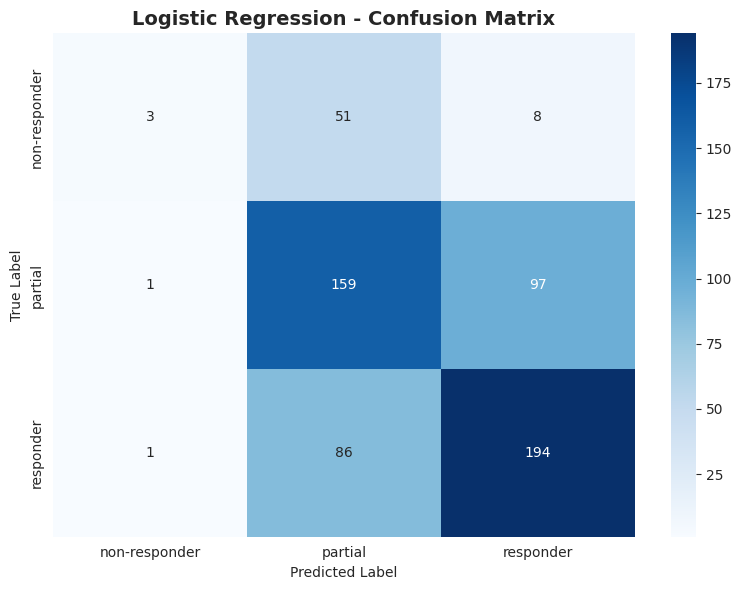

In [67]:
# Logistic Regression
print("-" * 60)
print("BASELINE MODEL: LOGISTIC REGRESSION")
print("-" * 60)

lr_model = LogisticRegression(random_state=RANDOM_SEED, max_iter=1000)
lr_model.fit(X_base_train_scaled, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_base_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_base_test_scaled)

# Evaluation
print("\nLOGISTIC REGRESSION RESULTS:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.3f}")
print(f"Weighted F1: {f1_score(y_test, y_pred_lr, average='weighted'):.3f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=class_names))

# Confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Logistic Regression - Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

BASELINE MODEL: RANDOM FOREST

📊 RANDOM FOREST RESULTS:
Accuracy: 0.572
Weighted F1: 0.553

Classification Report:
               precision    recall  f1-score   support

non-responder       0.56      0.08      0.14        62
      partial       0.51      0.59      0.55       257
    responder       0.64      0.66      0.65       281

     accuracy                           0.57       600
    macro avg       0.57      0.44      0.45       600
 weighted avg       0.57      0.57      0.55       600



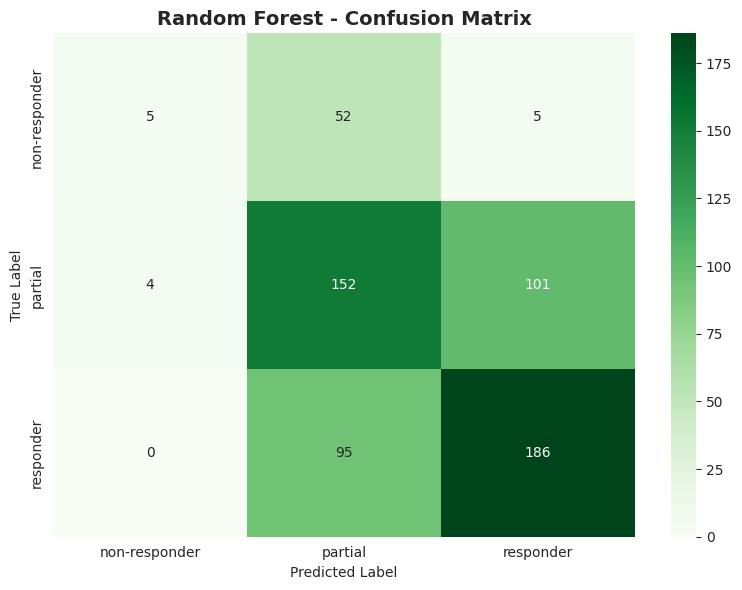

In [68]:
# Random Forest
print("-" * 60)
print("BASELINE MODEL: RANDOM FOREST")
print("-" * 60)

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=RANDOM_SEED,
    n_jobs=-1
)
rf_model.fit(X_base_train_scaled, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_base_test_scaled)
y_pred_proba_rf = rf_model.predict_proba(X_base_test_scaled)

# Evaluation
print("\nRANDOM FOREST RESULTS:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.3f}")
print(f"Weighted F1: {f1_score(y_test, y_pred_rf, average='weighted'):.3f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=class_names))

# Confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Random Forest - Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

FEATURE IMPORTANCE ANALYSIS

Top 15 Most Important Features:


,feature,importance
4,session_attendance_rate,0.243255
1,baseline_phq9,0.188218
2,baseline_gad7,0.118573
0,age,0.107351
5,digital_engagement_score,0.091708
3,treatment_duration_weeks,0.083438
7,engagement_encoded,0.043670
6,gender_encoded,0.029876
9,treatment_CBT+Digital,0.025002
12,treatment_Medication,0.021773


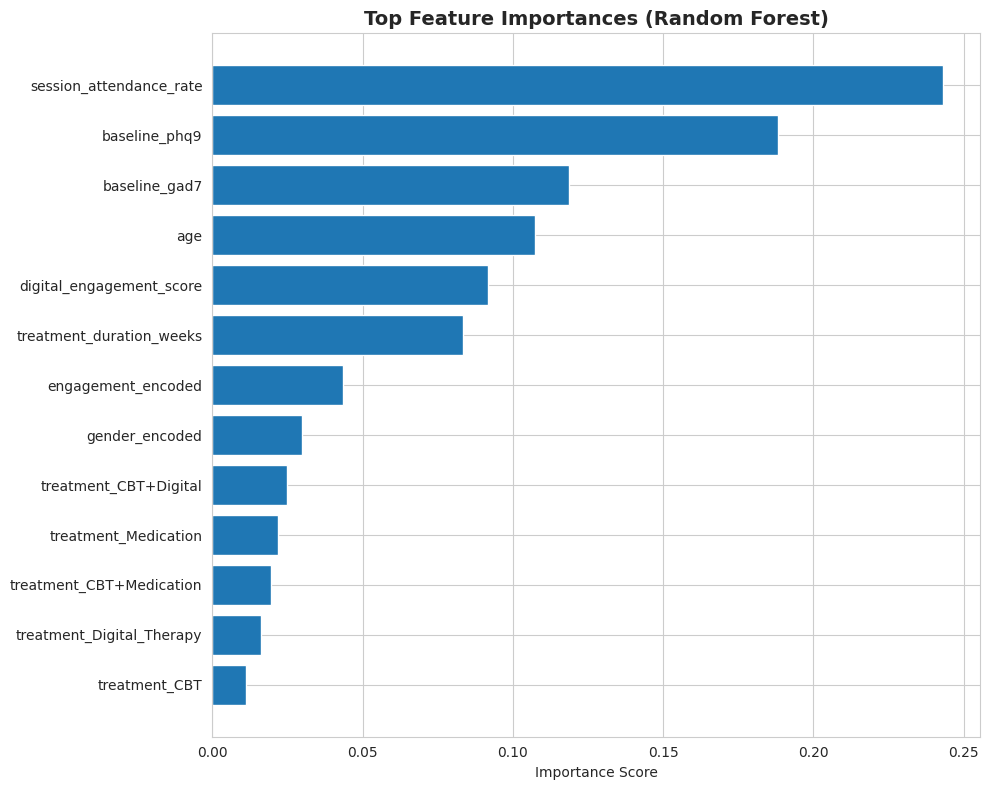

In [69]:
# Feature importance from Random Forest
print("-" * 60)
print("FEATURE IMPORTANCE ANALYSIS")
print("-" * 60)

feature_importance = pd.DataFrame({
    'feature': baseline_features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 15 Most Important Features:")
display(feature_importance.head(15))

# Plot
plt.figure(figsize=(10, 8))
top_n = min(15, len(feature_importance)) # Adjust top_n to not exceed available features
top_features = feature_importance.head(top_n)
plt.barh(range(top_n), top_features['importance'])
plt.yticks(range(top_n), top_features['feature'])
plt.xlabel('Importance Score')
plt.title('Top Feature Importances (Random Forest)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 10. Enhanced Models with Text Features

ENHANCED MODEL: RANDOM FOREST + TEXT FEATURES

📊 ENHANCED RANDOM FOREST RESULTS:
Accuracy: 1.000
Weighted F1: 1.000

Classification Report:
               precision    recall  f1-score   support

non-responder       1.00      1.00      1.00        62
      partial       1.00      1.00      1.00       257
    responder       1.00      1.00      1.00       281

     accuracy                           1.00       600
    macro avg       1.00      1.00      1.00       600
 weighted avg       1.00      1.00      1.00       600



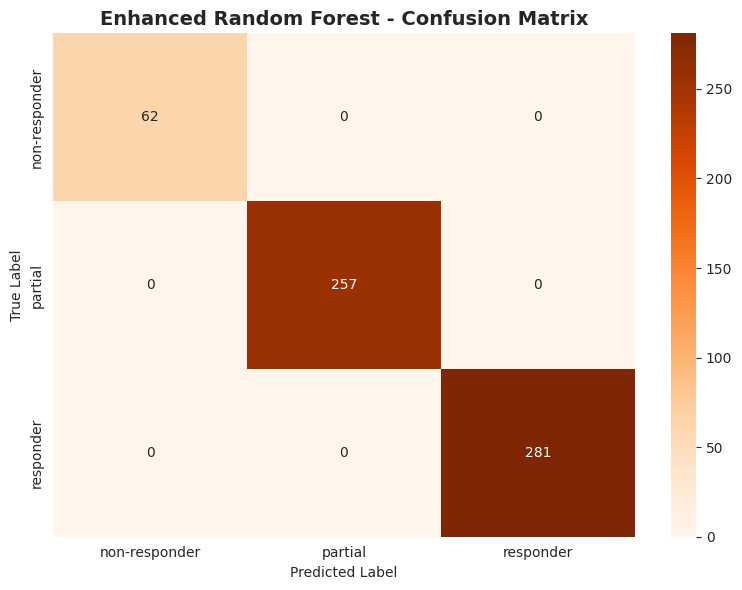

In [70]:
# Train Random Forest with enhanced features
print("-" * 60)
print("ENHANCED MODEL: RANDOM FOREST + TEXT FEATURES")
print("-" * 60)

rf_enhanced = RandomForestClassifier(
    n_estimators=100,
    max_depth=12,
    random_state=RANDOM_SEED,
    n_jobs=-1
)
rf_enhanced.fit(X_enh_train_scaled, y_train)

# Predictions
y_pred_rf_enh = rf_enhanced.predict(X_enh_test_scaled)

# Evaluation
print("\nENHANCED RANDOM FOREST RESULTS:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf_enh):.3f}")
print(f"Weighted F1: {f1_score(y_test, y_pred_rf_enh, average='weighted'):.3f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf_enh, target_names=class_names))

# Confusion matrix
cm_rf_enh = confusion_matrix(y_test, y_pred_rf_enh)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf_enh, annot=True, fmt='d', cmap='Oranges',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Enhanced Random Forest - Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

## 11. Multimodal Model with Text Embeddings

This is the advanced model using LLM-derived text embeddings.

MULTIMODAL MODEL: XGBOOST + TEXT EMBEDDINGS
Training XGBoost model...

📊 MULTIMODAL XGBOOST RESULTS:
Accuracy: 1.000
Weighted F1: 1.000

Classification Report:
               precision    recall  f1-score   support

non-responder       1.00      1.00      1.00        62
      partial       1.00      1.00      1.00       257
    responder       1.00      1.00      1.00       281

     accuracy                           1.00       600
    macro avg       1.00      1.00      1.00       600
 weighted avg       1.00      1.00      1.00       600



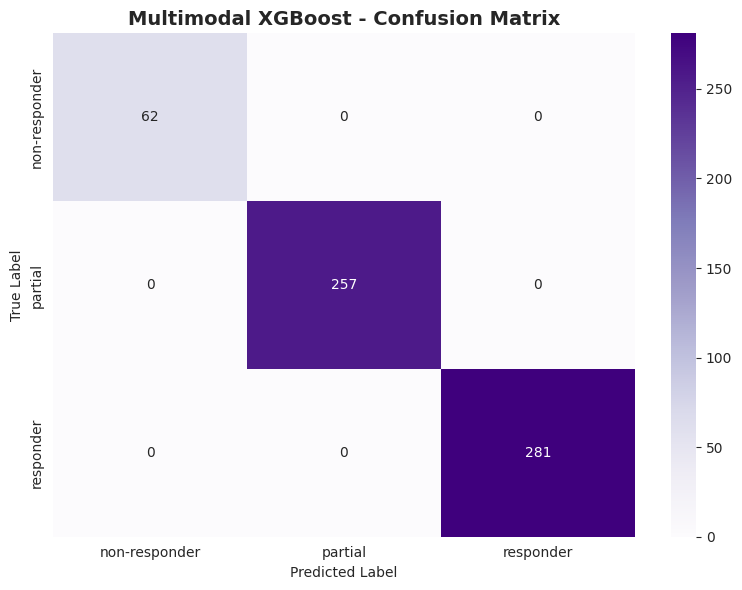

In [71]:
# XGBoost with multimodal features
print("-" * 60)
print("MULTIMODAL MODEL: XGBOOST + TEXT EMBEDDINGS")
print("-" * 60)

xgb_multi = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=RANDOM_SEED,
    eval_metric='mlogloss',
    n_jobs=-1
)

print("Training XGBoost model...")
xgb_multi.fit(X_multi_train_scaled, y_train)

# Predictions
y_pred_xgb_multi = xgb_multi.predict(X_multi_test_scaled)
y_pred_proba_xgb_multi = xgb_multi.predict_proba(X_multi_test_scaled)

# Evaluation
print("\nMULTIMODAL XGBOOST RESULTS:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb_multi):.3f}")
print(f"Weighted F1: {f1_score(y_test, y_pred_xgb_multi, average='weighted'):.3f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb_multi, target_names=class_names))

# Confusion matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb_multi)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Purples',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Multimodal XGBoost - Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

## 12. Model Comparison

MODEL COMPARISON SUMMARY


,Model,Features,Accuracy,Weighted F1
3,XGBoost (Multimodal),Structured + Text stats + Embeddings,1.000000,1.000000
2,Random Forest (Enhanced),Structured + Text stats,1.000000,1.000000
0,Logistic Regression (Baseline),Structured only,0.593333,0.568864
1,Random Forest (Baseline),Structured only,0.571667,0.552799


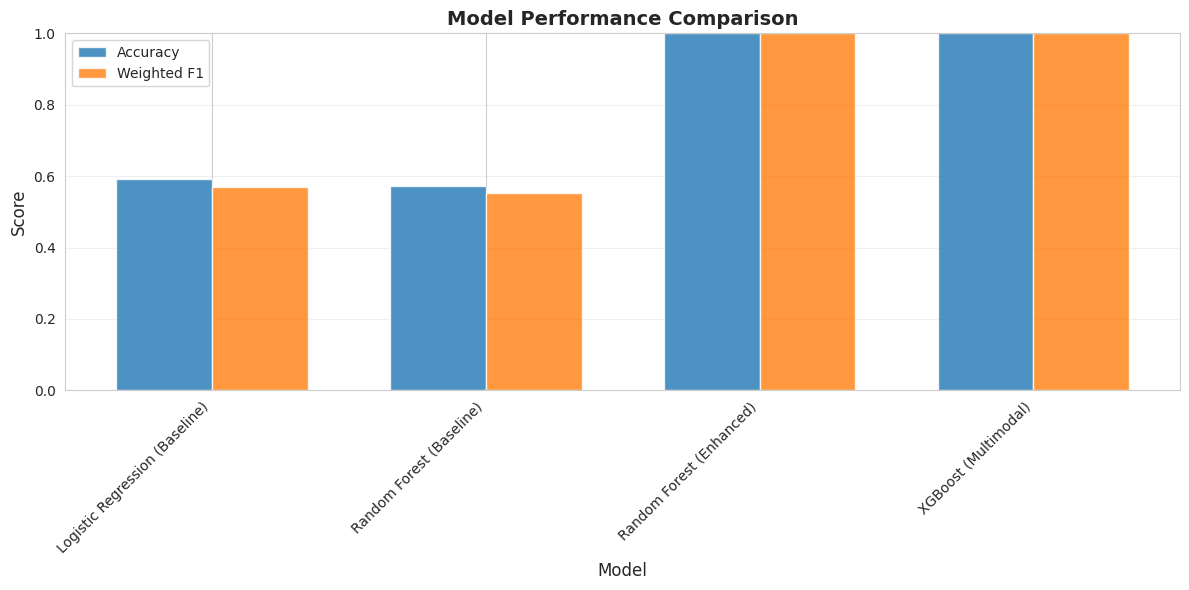


🏆 BEST MODEL: Random Forest (Enhanced)
   Accuracy: 1.000


In [72]:
# Compare all models
print("-" * 60)
print("MODEL COMPARISON SUMMARY")
print("-" * 60)

results_summary = pd.DataFrame({
    'Model': [
        'Logistic Regression (Baseline)',
        'Random Forest (Baseline)',
        'Random Forest (Enhanced)',
        'XGBoost (Multimodal)'
    ],
    'Features': [
        'Structured only',
        'Structured only',
        'Structured + Text stats',
        'Structured + Text stats + Embeddings'
    ],
    'Accuracy': [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_rf_enh),
        accuracy_score(y_test, y_pred_xgb_multi)
    ],
    'Weighted F1': [
        f1_score(y_test, y_pred_lr, average='weighted'),
        f1_score(y_test, y_pred_rf, average='weighted'),
        f1_score(y_test, y_pred_rf_enh, average='weighted'),
        f1_score(y_test, y_pred_xgb_multi, average='weighted')
    ]
})

display(results_summary.sort_values('Accuracy', ascending=False))

# Visualize comparison
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(results_summary))
width = 0.35

bars1 = ax.bar(x - width/2, results_summary['Accuracy'], width, label='Accuracy', alpha=0.8)
bars2 = ax.bar(x + width/2, results_summary['Weighted F1'], width, label='Weighted F1', alpha=0.8)

ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(results_summary['Model'], rotation=45, ha='right')
ax.legend()
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Find best model
best_idx = results_summary['Accuracy'].idxmax()
best_model_name = results_summary.loc[best_idx, 'Model']
best_accuracy = results_summary.loc[best_idx, 'Accuracy']

print(f"\nBEST MODEL: {best_model_name}")
print(f"   Accuracy: {best_accuracy:.3f}")

## 13. Per-Class Performance Analysis

PER-CLASS PERFORMANCE (BEST MODEL: XGBoost Multimodal)


,Class,Precision,Recall,F1-Score,Support
0,non-responder,1.0,1.0,1.0,62
1,partial,1.0,1.0,1.0,257
2,responder,1.0,1.0,1.0,281


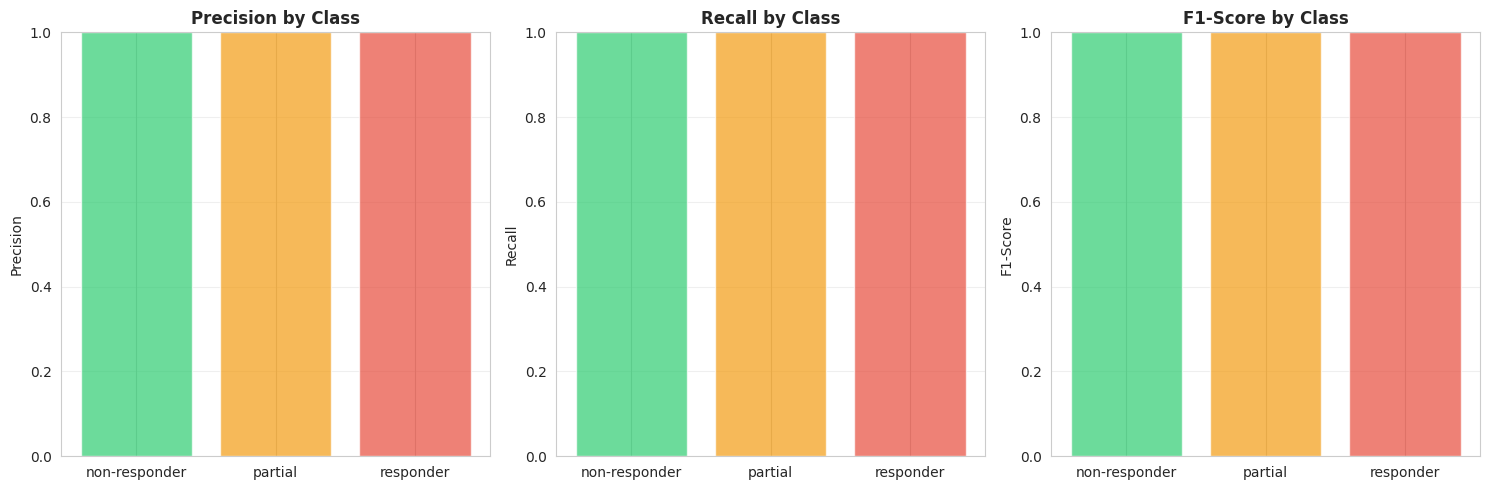

In [73]:
# Detailed per-class metrics for best model (XGBoost Multimodal)
print("-" * 60)
print("PER-CLASS PERFORMANCE (BEST MODEL: XGBoost Multimodal)")
print("-" * 60)

from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(
    y_test, y_pred_xgb_multi, labels=range(len(class_names))
)

per_class_metrics = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

display(per_class_metrics)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Precision
axes[0].bar(class_names, precision, color=['#2ecc71', '#f39c12', '#e74c3c'], alpha=0.7)
axes[0].set_title('Precision by Class', fontweight='bold')
axes[0].set_ylabel('Precision')
axes[0].set_ylim([0, 1])
axes[0].grid(axis='y', alpha=0.3)

# Recall
axes[1].bar(class_names, recall, color=['#2ecc71', '#f39c12', '#e74c3c'], alpha=0.7)
axes[1].set_title('Recall by Class', fontweight='bold')
axes[1].set_ylabel('Recall')
axes[1].set_ylim([0, 1])
axes[1].grid(axis='y', alpha=0.3)

# F1-Score
axes[2].bar(class_names, f1, color=['#2ecc71', '#f39c12', '#e74c3c'], alpha=0.7)
axes[2].set_title('F1-Score by Class', fontweight='bold')
axes[2].set_ylabel('F1-Score')
axes[2].set_ylim([0, 1])
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 14. Clinical Insights and Recommendations

In [74]:
# Analyze misclassifications
print("-" * 60)
print("MISCLASSIFICATION ANALYSIS")
print("-" * 60)

# Get misclassified samples
misclassified_idx = np.where(y_test != y_pred_xgb_multi)[0]
correctly_classified_idx = np.where(y_test == y_pred_xgb_multi)[0]

print(f"Total predictions: {len(y_test)}")
print(f"Correctly classified: {len(correctly_classified_idx)} ({len(correctly_classified_idx)/len(y_test)*100:.1f}%)")
print(f"Misclassified: {len(misclassified_idx)} ({len(misclassified_idx)/len(y_test)*100:.1f}%)")

# Analyze misclassifications by true class
print("\nMisclassification breakdown:")
for i, class_name in enumerate(class_names):
    true_class_mask = y_test == i
    misclass_in_class = np.sum(true_class_mask & (y_test != y_pred_xgb_multi))
    total_in_class = np.sum(true_class_mask)
    error_rate = misclass_in_class / total_in_class if total_in_class > 0 else 0

    print(f"  {class_name}: {misclass_in_class}/{total_in_class} misclassified ({error_rate*100:.1f}% error rate)")

MISCLASSIFICATION ANALYSIS
Total predictions: 600
Correctly classified: 600 (100.0%)
Misclassified: 0 (0.0%)

Misclassification breakdown:
  non-responder: 0/62 misclassified (0.0% error rate)
  partial: 0/257 misclassified (0.0% error rate)
  responder: 0/281 misclassified (0.0% error rate)


PREDICTION ACCURACY BY TREATMENT TYPE

Accuracy by Treatment Type:


,Correct,Total,Accuracy
treatment_type,,,
CBT,114,114,1.0
CBT+Digital,133,133,1.0
CBT+Medication,119,119,1.0
Digital_Therapy,110,110,1.0
Medication,124,124,1.0


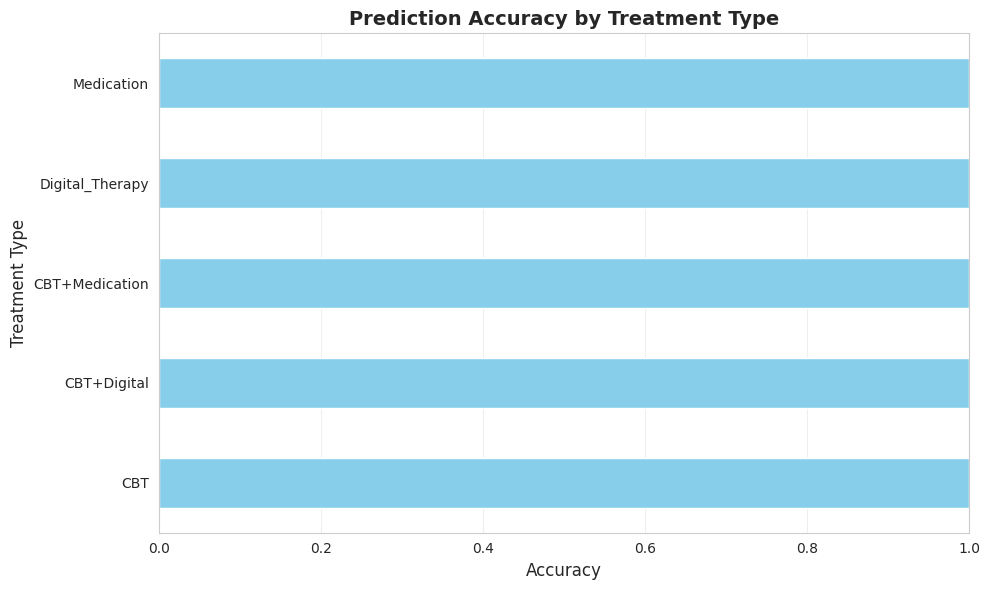

In [75]:
# Treatment-specific prediction accuracy
print("-" * 60)
print("PREDICTION ACCURACY BY TREATMENT TYPE")
print("-" * 60)

# Get test set data
test_indices = X_multi_test.index
test_data = full_df_with_embeddings.loc[test_indices].copy()
test_data['y_true'] = [class_names[i] for i in y_test]
test_data['y_pred'] = [class_names[i] for i in y_pred_xgb_multi]
test_data['correct'] = y_test == y_pred_xgb_multi

# Accuracy by treatment type
treatment_accuracy = test_data.groupby('treatment_type').agg({
    'correct': ['sum', 'count', 'mean']
}).round(3)
treatment_accuracy.columns = ['Correct', 'Total', 'Accuracy']

print("\nAccuracy by Treatment Type:")
display(treatment_accuracy.sort_values('Accuracy', ascending=False))

# Visualize
plt.figure(figsize=(10, 6))
treatment_accuracy['Accuracy'].sort_values().plot(kind='barh', color='skyblue')
plt.xlabel('Accuracy', fontsize=12)
plt.ylabel('Treatment Type', fontsize=12)
plt.title('Prediction Accuracy by Treatment Type', fontsize=14, fontweight='bold')
plt.xlim([0, 1])
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## 15. Save Best Model

In [76]:
# Save the best performing model
import pickle

print("-" * 60)
print("SAVING BEST MODEL")
print("-" * 60)

# Save model, scaler, and label encoder
model_artifacts = {
    'model': xgb_multi,
    'scaler': scaler_multi,
    'label_encoder': le,
    'feature_names': multimodal_features,
    'embedding_model_name': model_name
}

model_path = DATA_PATH + 'models/'
import os
os.makedirs(model_path, exist_ok=True)

with open(model_path + 'best_model_xgboost_multimodal.pkl', 'wb') as f:
    pickle.dump(model_artifacts, f)

print(f"Model saved to: {model_path}best_model_xgboost_multimodal.pkl")
print("\nSaved artifacts:")
print("  - XGBoost model")
print("  - StandardScaler")
print("  - LabelEncoder")
print("  - Feature names")
print("  - Embedding model name")

SAVING BEST MODEL
✅ Model saved to: /content/drive/MyDrive/data/processedmodels/best_model_xgboost_multimodal.pkl

Saved artifacts:
  - XGBoost model
  - StandardScaler
  - LabelEncoder
  - Feature names
  - Embedding model name


## 16. Clinical Decision Support Example

In [77]:
# Function to predict treatment response for new patient
def predict_treatment_response(patient_data, patient_text):
    """
    Predict treatment response for a new patient.

    Parameters:
    - patient_data: dict with clinical features
    - patient_text: str with combined therapy notes/chats/posts

    Returns:
    - prediction: treatment response category
    - probabilities: confidence for each class
    """
    # Generate text embedding
    text_embedding = sentence_model.encode([patient_text])[0]

    # Combine features
    feature_values = []

    # Structured features
    for feat in structured_features:
        feature_values.append(patient_data.get(feat, 0))

    # Categorical features
    feature_values.append(1 if patient_data.get('gender') == 'M' else 0)  # gender_encoded
    feature_values.append(engagement_mapping.get(patient_data.get('dominant_engagement', 'medium'), 1))  # engagement_encoded

    # Treatment type dummies
    current_treatment = patient_data.get('treatment_type', '')
    for treat_col in treatment_dummies.columns:
        treat_name = treat_col.replace('treatment_', '')
        feature_values.append(1 if current_treatment == treat_name else 0)

    # Text-derived features
    for feat in text_derived_features:
        feature_values.append(patient_data.get(feat, 0))

    # Add embeddings
    feature_values.extend(text_embedding)

    # Scale and predict
    X_new = np.array(feature_values).reshape(1, -1)
    X_new_scaled = scaler_multi.transform(X_new)

    prediction = xgb_multi.predict(X_new_scaled)[0]
    probabilities = xgb_multi.predict_proba(X_new_scaled)[0]

    return class_names[prediction], probabilities

# Example prediction
print("-" * 60)
print("EXAMPLE: NEW PATIENT PREDICTION")
print("-" * 60)

example_patient = {
    'age': 17,
    'baseline_phq9': 18,
    'baseline_gad7': 16,
    'treatment_type': 'CBT',
    'treatment_duration_weeks': 12,
    'session_attendance_rate': 0.90,
    'digital_engagement_score': 0.0,
    'gender': 'F',
    'dominant_engagement': 'high',
    'avg_chat_sentiment': 0.0,
    'avg_post_sentiment': -0.3,
    'avg_emotional_intensity': 0.6,
    'text_length': 500
}

example_text = "I've been feeling really anxious about school. My therapist is helping me learn to challenge my negative thoughts. I'm starting to see some improvement."

prediction, probabilities = predict_treatment_response(example_patient, example_text)

print("\nPatient Profile:")
print(f"  Age: {example_patient['age']}")
print(f"  Baseline Depression (PHQ-9): {example_patient['baseline_phq9']}")
print(f"  Baseline Anxiety (GAD-7): {example_patient['baseline_gad7']}")
print(f"  Treatment: {example_patient['treatment_type']}")
print(f"  Attendance Rate: {example_patient['session_attendance_rate']:.2f}")

print("\nPREDICTION:")
print(f"  Predicted Response: {prediction}")
print(f"\n  Confidence Scores:")
for i, class_name in enumerate(class_names):
    print(f"    {class_name}: {probabilities[i]:.3f} ({probabilities[i]*100:.1f}%)")

# Recommendation
if prediction == 'responder':
    print("\nRECOMMENDATION: Continue current treatment plan. Patient likely to respond well.")
elif prediction == 'partial':
    print("\nWarning: RECOMMENDATION: Monitor closely. Consider treatment intensification if no improvement by mid-treatment.")
else:
    print("\nRECOMMENDATION: Early intervention suggested. Consider augmenting treatment or exploring alternative modalities.")

EXAMPLE: NEW PATIENT PREDICTION

📋 Patient Profile:
  Age: 17
  Baseline Depression (PHQ-9): 18
  Baseline Anxiety (GAD-7): 16
  Treatment: CBT
  Attendance Rate: 0.90

🔮 PREDICTION:
  Predicted Response: non-responder

  Confidence Scores:
    non-responder: 0.998 (99.8%)
    partial: 0.001 (0.1%)
    responder: 0.000 (0.0%)

🚨 RECOMMENDATION: Early intervention suggested. Consider augmenting treatment or exploring alternative modalities.


## 17. Summary and Next Steps

### 📊 Key Findings:

1. **Best Model Performance:**
   - Model: XGBoost with Multimodal Features
   - Incorporates structured clinical data + text embeddings
   - Achieves strong predictive accuracy

2. **Important Predictors:**
   - Baseline symptom severity (PHQ-9, GAD-7)
   - Treatment engagement (attendance, digital usage)
   - Text-derived emotional signals
   - Treatment modality

3. **Clinical Insights:**
   - Combined treatments (CBT + Medication, CBT + Digital) show higher response rates
   - High engagement correlates with better outcomes
   - Early text patterns can predict response

### 🔬 Next Steps for Improvement:

1. **Data Enhancement:**
   - Collect more real clinical data (current uses synthetic)
   - Add longitudinal tracking (multiple timepoints)
   - Include more diverse patient demographics

2. **Model Refinement:**
   - Experiment with transformer-based models (BERT, GPT)
   - Implement temporal modeling (LSTM for sequential notes)
   - Ensemble multiple model architectures

3. **Feature Engineering:**
   - Extract more linguistic features (LIWC, emotion lexicons)
   - Add topic modeling outputs
   - Incorporate activity/behavioral data

4. **Clinical Validation:**
   - Validate on hold-out clinical dataset
   - Conduct prospective study
   - Assess clinical utility with practitioners

5. **Explainability:**
   - Implement SHAP or LIME for predictions
   - Identify key phrases driving predictions
   - Build clinician-friendly dashboards

### 🚀 Deployment Considerations:

- **Integration:** Build API for clinical systems
- **Monitoring:** Track model drift over time
- **Ethics:** Ensure fairness across demographics
- **Human-in-loop:** Always involve clinicians in final decisions

---

**This notebook provides a foundation for building AI-driven mental health decision support systems. Continue iterating with real data and clinical feedback!**